# Problem Statement:

Through the analysis and modeling of the Ames, Iowa dataset of 2006 - 2010 home sales, can a best mix of features be constructed to predict the sale price of homes in a given market? 

# Executive Summary

Through careful data analysis and regression modeling, I have been able to accurately predict housing prices off of a collection of 80+ data points for each Ames, Iowa home sale to a mean R Squared score of over .95, and a Root Mean Squared Error of ~18,000.

In order to accomplish this, I first cleaned the data of any missing values, and replaced those values with my best judgement when applicable.  Given that this is a generalized housing price predictor model for a city, I allowed myself to generalize some of the missing values, specifically for the category of 'Lot Frontage'.  This feature had a relatively weak correlation to the home Sale Price, but since I did not want to lose the valuable training data available in rows with missing information, I generalized the missing value to the mean for the category as a whole. The model improved as a result of this, and I take that as confirmation that it was an adequate solution to unfortunate data problem.  Again, given the relatively low stakes of the modeling challenge, I felt more inclined to aim for high accuracy than reduce substantial failure to predict outliers.  

Next, it was important to dig through categorical features and decide whether it would be better to one hot encode them, or restate them as ranked numerical data.  After A/B testing models of many of these features both ways, I chose to dummy encode almost every feature, trusting the regression model to construct a more accurate mathematical interpretation of the categories than my arbitrarily weighted rankings were able to.  

In addition, before getting a baseline model, I dug through the strongest correlations to the target variable, 'Sale Price', and followed my insights from the data exploration process to manually combine some of the strongest correlated features.  Through this process I discovered new polynomial features that turned out to have a higher correlation to the target than any of the original categories.  To enhance this feature's potential, I normalized its distribution by taking its natural log, and then used this logarithm as a multiplier for each value in my features DataFrame for the model.  At that point, the target distribution was also normalized by taking its logarithm and the modeling process began.  

3 models were tested and K-Fold cross validated.  Linear regression used the original data, but for the Lasso and Ridge regression models, I first normalized the data via Standard Scaler, and then fit and tested them.  While the results were relatively similar across models, the best result came from the Lasso Regression.  Lastly, I plotted the residual errors from my test, added them as a series in my DataFrame, scoured through the results.  And ultimately decided to toss out any rows that were more than three standard deviations away from the mean.  As of this writing, this model is the most accurate (#1) linear regression model for this data set amongst all participants.

On with the show!

<h1>Data Importing and Munging<h1>

<h2>Import Packages<h2>

In [1]:
#basic DS packages

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#for all models
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, PowerTransformer
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm

#for regression models
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV


#for Jupyter notebook:
%matplotlib inline

## Import Data into DataFrame

#### Data Dictionary can be found at: <a href="http://jse.amstat.org/v19n3/decock/DataDocumentation.txt">THIS LINK</a>

In [2]:
df = pd.read_csv('./datasets/train.csv')
outside_df = pd.read_csv('./datasets/test.csv')

In [3]:
#Remove the max column setting in pandas

pd.options.display.max_columns = None
pd.options.display.max_rows = None

<h2>Explore the Data</h2>

<h4>How many rows and columns are we dealing with?</h4>

In [4]:
#2051 rows and 81 columns of data

df.shape

(2051, 81)

In [5]:
outside_df.shape

(879, 80)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
Id                 2051 non-null int64
PID                2051 non-null int64
MS SubClass        2051 non-null int64
MS Zoning          2051 non-null object
Lot Frontage       1721 non-null float64
Lot Area           2051 non-null int64
Street             2051 non-null object
Alley              140 non-null object
Lot Shape          2051 non-null object
Land Contour       2051 non-null object
Utilities          2051 non-null object
Lot Config         2051 non-null object
Land Slope         2051 non-null object
Neighborhood       2051 non-null object
Condition 1        2051 non-null object
Condition 2        2051 non-null object
Bldg Type          2051 non-null object
House Style        2051 non-null object
Overall Qual       2051 non-null int64
Overall Cond       2051 non-null int64
Year Built         2051 non-null int64
Year Remod/Add     2051 non-null int64
Roof Style         20

### View Outliers

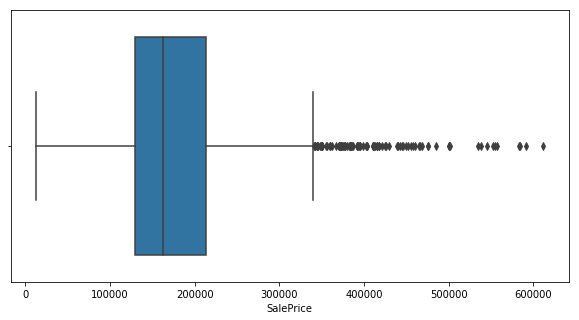

In [7]:
plt.figure(figsize = (10,5))

sns.boxplot(df['SalePrice'])

In [8]:
df.sort_values('SalePrice', ascending = False).head(8)

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
1671,45,528150070,20,RL,100.0,12919,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,9,5,2009,2010,Hip,CompShg,VinylSd,VinylSd,Stone,760.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,2188.0,Unf,0.0,142.0,2330.0,GasA,Ex,Y,SBrkr,2364,0,0,2364,1.0,0.0,2,1,2,1,Ex,11,Typ,2,Gd,Attchd,2009.0,Fin,3.0,820.0,TA,TA,Y,0,67,0,0,0,0,NaN,NaN,NaN,0,3,2010,New,611657
1964,1638,527216080,20,RL,52.0,51974,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,StoneBr,PosN,Norm,1Fam,1Story,9,5,2006,2007,Hip,CompShg,VinylSd,VinylSd,BrkFace,710.0,Ex,TA,PConc,Ex,TA,Av,GLQ,1101.0,Unf,0.0,1559.0,2660.0,GasA,Ex,Y,SBrkr,2338,0,0,2338,1.0,0.0,2,1,4,1,Gd,8,Typ,2,Gd,Attchd,2005.0,Fin,3.0,1110.0,Gd,TA,Y,0,135,0,0,322,0,NaN,NaN,NaN,0,6,2007,New,591587
1692,2451,528360050,60,RL,114.0,17242,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NoRidge,Norm,Norm,1Fam,2Story,9,5,1993,1994,Hip,CompShg,MetalSd,MetalSd,BrkFace,738.0,Gd,Gd,PConc,Ex,TA,Gd,Rec,292.0,GLQ,1393.0,48.0,1733.0,GasA,Ex,Y,SBrkr,1933,1567,0,3500,1.0,0.0,3,1,4,1,Ex,11,Typ,1,TA,Attchd,1993.0,RFn,3.0,959.0,TA,TA,Y,870,86,0,0,210,0,NaN,NaN,NaN,0,5,2006,WD,584500
1796,434,528110090,60,RL,107.0,13891,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,2Story,9,5,2008,2009,Hip,CompShg,VinylSd,VinylSd,Stone,424.0,Ex,TA,PConc,Ex,TA,Gd,Unf,0.0,Unf,0.0,1734.0,1734.0,GasA,Ex,Y,SBrkr,1734,1088,0,2822,0.0,0.0,3,1,4,1,Ex,12,Typ,1,Gd,BuiltIn,2009.0,RFn,3.0,1020.0,TA,TA,Y,52,170,0,0,192,0,NaN,NaN,NaN,0,1,2009,New,582933
151,2333,527212030,60,RL,85.0,16056,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,StoneBr,Norm,Norm,1Fam,2Story,9,5,2005,2006,Hip,CompShg,CemntBd,CmentBd,Stone,208.0,Gd,TA,PConc,Ex,TA,Av,GLQ,240.0,Unf,0.0,1752.0,1992.0,GasA,Ex,Y,SBrkr,1992,876,0,2868,0.0,0.0,3,1,4,1,Ex,11,Typ,1,Gd,BuiltIn,2005.0,Fin,3.0,716.0,TA,TA,Y,214,108,0,0,0,0,NaN,NaN,NaN,0,7,2006,New,556581
1164,424,528106020,20,RL,105.0,15431,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,10,5,2008,2008,Hip,CompShg,VinylSd,VinylSd,Stone,200.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,1767.0,ALQ,539.0,788.0,3094.0,GasA,Ex,Y,SBrkr,2402,0,0,2402,1.0,0.0,2,0,2,1,Ex,10,Typ,2,Gd,Attchd,2008.0,Fin,3.0,672.0,TA,TA,Y,0,72,0,0,170,0,NaN,NaN,NaN,0,4,2009,WD,555000
623,457,528176030,20,RL,100.0,14836,Pave,NaN,IR1,HLS,AllPub,Inside,Mod,NridgHt,Norm,Norm,1Fam,1Story,10,5,2004,2005,Hip,CompShg,CemntBd,CmentBd,Stone,730.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,2146.0,Unf,0.0,346.0,2492.0,GasA,Ex,Y,SBrkr,2492,0,0,2492,1.0,0.0,2,1,2,1,Ex,8,Typ,1,Ex,Attchd,2004.0,Fin,3.0,949.0,TA,TA,Y,226,235,0,0,0,0,NaN,NaN,NaN,0,2,2009,WD,552000
138,2331,527210040,60,RL,60.0,18062,Pave,NaN,IR1,HLS,AllPub,CulDSac,Gtl,StoneBr,Norm,Norm,1Fam,2Story,10,5,2006,2006,Hip,CompShg,CemntBd,CmentBd,BrkFace,662.0,Ex,TA,PConc,Ex,TA,Gd,Unf,0.0,Unf,0.0,1528.0,1528.0,GasA,Ex,Y,SBrkr,1528,1862,0,3390,0.0,0.0,3,1,5,1,Ex,10,Typ,1,Ex,BuiltIn,2006.0,Fin,3.0,758.0,TA,TA,Y,204,34,0,0,0,0,NaN,NaN,NaN,0,9,2006,New,545224


In [9]:
#Drop sale price outlier

#df.drop([1628,183] , inplace = True)

<h2>Dealing with NaN's</h2>

<h3>Consult the Data Dictionary

<h4>Determine NaN's for Categorical Data and Replace/Drop</h4>

In [10]:
#Calculate null quantities for all categorical columns, and replace NaN with none.
#I have manually checked the data dictionary to confirm that this is an adequate solution.

null_cat_columns = []  #Saves list of the NaN category columns that have been filled with 'None'. Only for reference.  

for i in df:
    if (df[i].isnull().sum() > 0) & (df[i].dtype == 'O'):
        null_cat_columns.append(i)
        df[i].fillna('None', inplace = True)


In [11]:
#Above for outside df

for i in outside_df:
    if (outside_df[i].isnull().sum() > 0) & (outside_df[i].dtype == 'O'):
        null_cat_columns.append(i)
        outside_df[i].fillna('None', inplace = True)

In [12]:
outside_df.isnull().sum()

Id                   0
PID                  0
MS SubClass          0
MS Zoning            0
Lot Frontage       160
Lot Area             0
Street               0
Alley                0
Lot Shape            0
Land Contour         0
Utilities            0
Lot Config           0
Land Slope           0
Neighborhood         0
Condition 1          0
Condition 2          0
Bldg Type            0
House Style          0
Overall Qual         0
Overall Cond         0
Year Built           0
Year Remod/Add       0
Roof Style           0
Roof Matl            0
Exterior 1st         0
Exterior 2nd         0
Mas Vnr Type         0
Mas Vnr Area         1
Exter Qual           0
Exter Cond           0
Foundation           0
Bsmt Qual            0
Bsmt Cond            0
Bsmt Exposure        0
BsmtFin Type 1       0
BsmtFin SF 1         0
BsmtFin Type 2       0
BsmtFin SF 2         0
Bsmt Unf SF          0
Total Bsmt SF        0
Heating              0
Heating QC           0
Central Air          0
Electrical 

<h4>Determine NaN's for Non-Categorical Data and Replace/Drop</h4>

In [13]:
#List null quantities for non-categorical quantities.
#These lists are useful because there are SO many columns, that many get cut off when checking manually with .isnull()

for i in df:
    if (df[i].isnull().sum() > 0):
        print(f'{i}: \nTotal: {df[i].isnull().sum()}\nPct: {df[i].isnull().mean()}\n')

Lot Frontage: 
Total: 330
Pct: 0.16089712335446124

Mas Vnr Area: 
Total: 22
Pct: 0.010726474890297415

BsmtFin SF 1: 
Total: 1
Pct: 0.00048756704046806434

BsmtFin SF 2: 
Total: 1
Pct: 0.00048756704046806434

Bsmt Unf SF: 
Total: 1
Pct: 0.00048756704046806434

Total Bsmt SF: 
Total: 1
Pct: 0.00048756704046806434

Bsmt Full Bath: 
Total: 2
Pct: 0.0009751340809361287

Bsmt Half Bath: 
Total: 2
Pct: 0.0009751340809361287

Garage Yr Blt: 
Total: 114
Pct: 0.05558264261335934

Garage Cars: 
Total: 1
Pct: 0.00048756704046806434

Garage Area: 
Total: 1
Pct: 0.00048756704046806434



In [14]:
df['Lot Frontage'].describe()

count    1721.000000
mean       69.055200
std        23.260653
min        21.000000
25%        58.000000
50%        68.000000
75%        80.000000
max       313.000000
Name: Lot Frontage, dtype: float64

In [15]:
#Replace NaN's with 0 for Masonry Veneer Type, Basement Half Bath, and Basement Full Bath

df['Lot Frontage'].fillna(69, inplace = True) # 69 is the mean value of the category
df['Mas Vnr Area'].fillna(0, inplace = True)
df['Bsmt Half Bath'].fillna(0, inplace = True)
df['Bsmt Full Bath'].fillna(0, inplace = True)

In [16]:
outside_df['Lot Frontage'].describe()

count    719.000000
mean      69.630042
std       23.625372
min       21.000000
25%       59.000000
50%       68.000000
75%       80.000000
max      182.000000
Name: Lot Frontage, dtype: float64

In [17]:
outside_df['Lot Frontage'].fillna(69, inplace = True) # 69 is the mean value of the category
outside_df['Mas Vnr Area'].fillna(0, inplace = True)




<h4>Drop Unecessary Columns with too many NaN's to Manually Resolve</h4>

In [18]:
#Columns to drop
drop_columns = ['Garage Yr Blt']

df.drop(drop_columns, axis = 1, inplace = True)
outside_df.drop(drop_columns, axis = 1, inplace = True)

<h4>Manually isolate and replace remmaining NaN's</h4>

In [19]:
#Only row with NaN in specific basement columns
df.iloc[1327] = df.iloc[1327].fillna(0)

#Only row with NaN in specific garage columns
df.iloc[1712] = df.iloc[1712].fillna(0)

In [20]:
outside_df.isnull().sum().sum()

0

## Measure Initial Feature Correlations

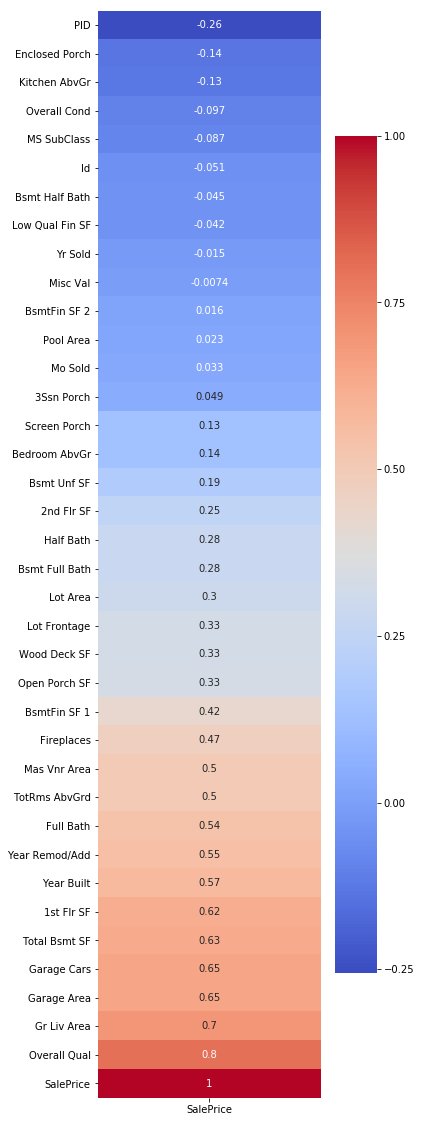

In [21]:
#Construct a heat map for the target variable, 'Sale Price' to determine its strongest correlations
plt.figure(figsize = (5,20))

sns.heatmap(df.corr()[['SalePrice']].sort_values('SalePrice'), annot = True, cmap = 'coolwarm')

<h2>Data Type Adjustment</h2>

In [22]:
#Save csv before dummying for analysis and visualization

df.to_csv('./datasets/aimes_kaggle_df_for_visualization.csv', index = False)

In [23]:
df.dtypes

Id                   int64
PID                  int64
MS SubClass          int64
MS Zoning           object
Lot Frontage       float64
Lot Area             int64
Street              object
Alley               object
Lot Shape           object
Land Contour        object
Utilities           object
Lot Config          object
Land Slope          object
Neighborhood        object
Condition 1         object
Condition 2         object
Bldg Type           object
House Style         object
Overall Qual         int64
Overall Cond         int64
Year Built           int64
Year Remod/Add       int64
Roof Style          object
Roof Matl           object
Exterior 1st        object
Exterior 2nd        object
Mas Vnr Type        object
Mas Vnr Area       float64
Exter Qual          object
Exter Cond          object
Foundation          object
Bsmt Qual           object
Bsmt Cond           object
Bsmt Exposure       object
BsmtFin Type 1      object
BsmtFin SF 1       float64
BsmtFin Type 2      object
B

<u><b>Note:</b></u>  Any categorical changes should be processed on both datasets simultaneously

<h4>Categorize Month & Year Sold (and Dummy)</h4>

In [24]:
#Create dummy df's for month and year, to be concatenated with the full df, but also available for later analysis.
#The point is to consider the strongest month and year combination features for the model

#For inside dataframe
mo_sold_dummy = pd.get_dummies(df['Mo Sold'], drop_first = True)
yr_sold_dummy = pd.get_dummies(df['Yr Sold'], drop_first = True)
mo_and_year_dummy = pd.concat([mo_sold_dummy, yr_sold_dummy], axis = 1)


# #For outside dataframe
mo_sold_dummy_out = pd.get_dummies(outside_df['Mo Sold'], drop_first = True)
yr_sold_dummy_out = pd.get_dummies(outside_df['Yr Sold'], drop_first = True)
mo_and_year_outside_dummy = pd.concat([mo_sold_dummy_out, yr_sold_dummy_out], axis = 1)





<h4>Create Polynomial Calendar Features</h4>

In [25]:
#instantiate a Polynomial Features variable.

poly = PolynomialFeatures(include_bias = False)

In [26]:
#Create a polynomial feature database of month and year combinations.  Irrational ones (i.e. Feb * Mar) to be dropped a few rows down.

#inside dataframe

mo_yr_poly = poly.fit_transform(mo_and_year_dummy)
mo_yr_poly_df = pd.DataFrame(mo_yr_poly, columns = poly.get_feature_names(mo_and_year_dummy.columns.astype(str)))


# #outside dataframe

mo_yr_poly_out = poly.fit_transform(mo_and_year_outside_dummy)
mo_yr_poly_outside_df = pd.DataFrame(mo_yr_poly_out, columns = poly.get_feature_names(mo_and_year_outside_dummy.columns.astype(str)))







In [27]:
mo_yr_poly_df.columns

Index(['2', '3', '4', '5', '6', '7', '8', '9', '10', '11',
       ...
       '2007^2', '2007 2008', '2007 2009', '2007 2010', '2008^2', '2008 2009',
       '2008 2010', '2009^2', '2009 2010', '2010^2'],
      dtype='object', length=135)

#### Do the same for Neighborhoods

In [28]:
#For inside dataframe
neighborhood_dummy = pd.get_dummies(df['Neighborhood'])

#For outside dataframe
outside_neighborhood_dummy = pd.get_dummies(outside_df['Neighborhood'])

In [29]:
neighborhood_dummy.columns

Index(['Blmngtn', 'Blueste', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr',
       'Crawfor', 'Edwards', 'Gilbert', 'Greens', 'GrnHill', 'IDOTRR',
       'Landmrk', 'MeadowV', 'Mitchel', 'NAmes', 'NPkVill', 'NWAmes',
       'NoRidge', 'NridgHt', 'OldTown', 'SWISU', 'Sawyer', 'SawyerW',
       'Somerst', 'StoneBr', 'Timber', 'Veenker'],
      dtype='object')

In [30]:
#Manually Created Polynomial Features influenced by above correlations.
df['LivArea_Qual'] = df['Gr Liv Area'] * df['Overall Qual'] #Log of this feature will be foundational for the model
df['Qual2'] = df['Overall Qual']**2  #Also including this for a slight model performance boost.


#Apply the above manual features to the outside data set.
outside_df['Qual2'] = outside_df['Overall Qual']**2
outside_df['LivArea_Qual'] = outside_df['Gr Liv Area'] * outside_df['Overall Qual']



In [31]:
# ***DROP AFTER PLOT***

#Create logs of our target, Sale Price, and the LivArea_Qual features to plot below.  

df['log'] = np.log(df['SalePrice'])
df['log2'] = np.log(df['log'])
df['log_LAQ'] = np.log(df['LivArea_Qual'])

#Two tests
df['Remod_log'] = df['Year Remod/Add'] * df['log_LAQ']
df['Remod_nolog'] = df['Year Remod/Add'] * df['LivArea_Qual']
df['Year Built_log'] = df['Year Built'] * df['log_LAQ']
df['Year Built_nolog'] = df['Year Built'] * df['LivArea_Qual']

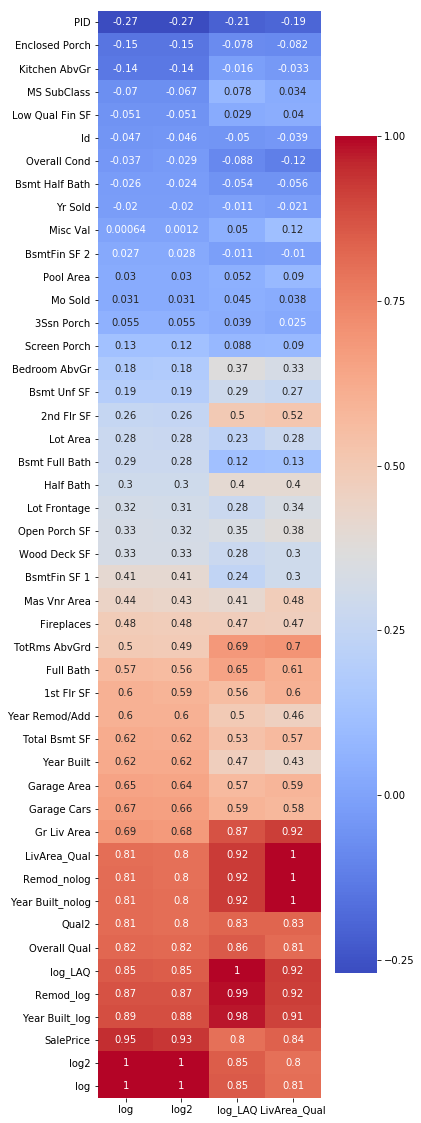

In [32]:
plt.figure(figsize = (5,20))

sns.heatmap(df.corr()[['log','log2','log_LAQ','LivArea_Qual']].sort_values('log'), annot = True, cmap = 'coolwarm')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2149e3c8>]],
      dtype=object)

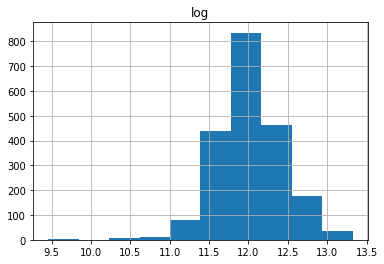

In [33]:
df.hist('log')

In [34]:
# ***DROPPING AFTER PLOT

df.drop(['log', 'log2','log_LAQ','Year Built_nolog','Year Built_log'], axis = 1, inplace = True)

In [35]:
#List and create ordinal features

list_of_ordinals = ['Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond', 'Kitchen Qual',
                   'Garage Qual', 'Garage Cond', 'Pool QC']

for i in df[list_of_ordinals]:
    df[i] = df[i].map({'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Fa' : 2, 'Po' : 1, 'None' : 0})
    
    
for i in outside_df[list_of_ordinals]:
    outside_df[i] = outside_df[i].map({'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Fa' : 2, 'Po' : 1, 'None' : 0})


In [36]:
# Manually created list of categorical variables to be dummied.  

list_to_dummy = ['Overall Qual','Sale Type','MS SubClass', 'MS Zoning', 'Street', 'Alley','Lot Shape', 'Land Contour',
                 'Utilities', 'Lot Config', 'Land Slope','Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 
                 'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
                 'Foundation','Bsmt Exposure','BsmtFin Type 1',
                 'BsmtFin Type 2','Heating','Heating QC','Central Air','Electrical','Functional',
                 'Fireplace Qu','Garage Type','Garage Finish','Paved Drive',
                 'Fence','Misc Feature']
                 
                 
                 #'Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond', 'Kitchen Qual',
                 #'Garage Qual', 'Garage Cond', 'Pool QC']


In [37]:
df.shape

(2051, 84)

In [38]:
outside_df.shape

(879, 81)

## Create Dummies and Add to DataFrames

In [39]:
#Create and add dummy columns from the above dummy list to 'df'
#df = pd.get_dummies(df, columns=list_to_dummy, drop_first = False)


#Create and add dummy columns from the above dummy list to 'outside_df'
#outside_df = pd.get_dummies(outside_df, columns=list_to_dummy, drop_first = False)


#Concatenate dataframe ('df') with calendar dataframes
df = pd.concat([df, mo_yr_poly_df], axis = 1)
outside_df = pd.concat([outside_df, mo_yr_poly_outside_df], axis = 1)


#Concatenate dataframes with Neighborhoods
df = pd.concat([df, neighborhood_dummy], axis = 1)
outside_df = pd.concat([outside_df, outside_neighborhood_dummy], axis = 1)

In [40]:
#print df and outside df features

print(df.shape)
print(outside_df.shape)

(2051, 247)
(879, 242)


<h3>Declare Target Feature (before dropping incompatible columns)</h3>

In [41]:
#Pull out 'SalePrice' before trimming dummy columns from dataframes
y = df['SalePrice']

<h3>Drop Columns with Zero Data in Either Dataframe</h3>

In [42]:
#Drop all dummy columns in df that doesn't have any values.  No value add if there is no data in the training df.

for col in df:
    if (df[col].min() == False) & (df[col].max() == False):
        df.drop(col, axis = 1, inplace = True)

In [43]:
df.shape

(2051, 181)

In [44]:
#Drop columns that are only in the outside DataFrame

for col in outside_df:
    if col not in df:
        outside_df.drop([col], axis = 1, inplace = True)

In [45]:
#Drop columns only in the inside DataFrame

for col in df:
    if col not in outside_df:
        df.drop([col], axis = 1, inplace = True)

In [46]:
#Confirm compatible shape of DataFrames
print(df.shape)
print(outside_df.shape)

(2051, 176)
(879, 176)


In [47]:
#Final Check for nulls.  

df.isnull().sum().sum()

0

<h2>Feature Selection</h2>

In [48]:
#Prepare the data to model

features = [col for col in df._get_numeric_data().columns]  #Thank Riley for this gem
X = df[features].drop(columns = ['Id','PID'])  #matrix

for feature in X:
    X[feature] = X[feature] * np.log(df['LivArea_Qual'])  
    
    #ABOVE:  This polynomial feature has the highest correlation to the target, so I am using it as a multiplier 

    
#Normalize the distribution by taking the natural log of y, the Sale Price    
y = np.log(np.log(y))


In [49]:
#Prepare the outside data set -- using the same multiplier from the outside data set

outside_features = [col for col in outside_df._get_numeric_data().columns]
outside_X = outside_df[outside_features].drop(columns = ['Id','PID'])  #matrix

for feature in outside_X:
    outside_X[feature] = outside_X[feature] * np.log(outside_df['LivArea_Qual'])

In [50]:
#Confirm that both the train(inside) and test(outside) Data Frames have the same amount of features

print(X.shape)
print(outside_X.shape)

(2051, 140)
(879, 140)


<h2>Modeling</h2>

<h3>Standard Scaler To Transform Data Into Z-Scores</h3>

In [51]:
#Instantiate a Standard Scaler object. 
ss = StandardScaler()

#Fit it to the inside data for Lasso and Ridge Regularization
ss.fit(X) 
X_scaled = ss.transform(X)


#Scaling outside data
outside_X_scaled = ss.transform(outside_X)


#Confirm column symmetry
print(X_scaled.shape)
print(outside_X_scaled.shape)

(2051, 140)
(879, 140)


### Instantiate Models

In [52]:
#Instantiate a Linear, Lasso, and Ridge regression objects.

lr = LinearRegression()
lasso = LassoCV(n_alphas=200, cv=5)
ridge = RidgeCV(alphas=np.linspace(.1, 10, 100))

### Cross Validation

In [53]:
#Cross Validation using Linear Regression
lr_scores = cross_val_score(lr, X, y, cv=5)
print(f'Linear Regression: {lr_scores.mean()}')


#Cross Validation using Lasso Regression
lasso_scores = cross_val_score(lasso, X, y, cv=7)
print(f'Lasso Regression: {lasso_scores.mean()}')


#Cross Validation using Ridge Regression
ridge_scores = cross_val_score(ridge, X, y, cv=7)
print(f'Ridge Regression: {ridge_scores.mean()}')

Linear Regression: 0.8688263505764018
Lasso Regression: 0.8078709448513047
Ridge Regression: 0.8649928242988152


<h3> Using Lasso Regression with Cross Validation</h3>

In [54]:
#Fit Lasso on the X_scaled training (inside) data

lasso.fit(X_scaled, y)
lasso.score(X_scaled, y)

0.8966106026954546

In [55]:
#Predicted 'y' values (natural log of house values) to compare to actual training data

lasso_pred = lasso.predict(X_scaled)

In [56]:
#Root Mean Squared Error

rmse = np.sqrt(mean_squared_error(y, lasso_pred))
rmse

0.011053148554963877

### Plot Residuals

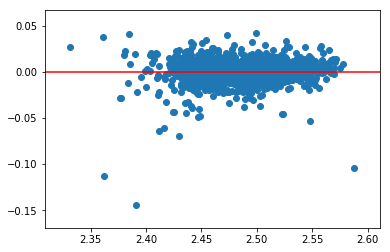

In [57]:
#Calculate the residuals and find their mean

residuals = y - lasso_pred
residuals.mean()

#Plot the resideuals on a scatter plot to find outliers
plt.scatter(x = lasso_pred, y = residuals)
plt.axhline(0, color='r')


In [58]:
df['residuals'] = residuals
df['residuals'].describe()

count    2.051000e+03
mean    -1.364097e-16
std      1.105584e-02
min     -1.446208e-01
25%     -4.961142e-03
50%      2.259999e-04
75%      5.552825e-03
max      4.245038e-02
Name: residuals, dtype: float64

In [59]:
# 3 standard deviations from the mean:

print(f'Upper Distribution Limit: {-1.125921e-16 + (3 * 1.013277e-02)}')
print(f'Lower Distribution Limit: {-1.125921e-16 - (3 * 1.013277e-02)}')

Upper Distribution Limit: 0.030398309999999887
Lower Distribution Limit: -0.03039831000000011


In [60]:
#Create a residuals column for the DataFrame
df['residuals'] = residuals

df[['Id','residuals']].sort_values('residuals', ascending = False).head(30)

,Id,residuals
463,2257,0.042450
2017,303,0.041054
1211,2893,0.040172
1372,766,0.037975
304,3,0.035327
1897,2738,0.033940
1249,2736,0.032389
140,19,0.032144
170,275,0.031135
766,1308,0.030032


### Remove Outliers

In [61]:
df.iloc[1]['residuals']

0.0013306201931087003

In [62]:
#Remove Outliers residuals that are hurting the model's performance (everything beyond 3 Standard Deviations)

for row in range(len(df)):
    if df.iloc[row]['residuals'] >= (df['residuals'].mean() + (3 * df['residuals'].std())):
        print(row)
        X.drop(row, inplace = True)
        y.drop(row, inplace = True)
        
for row in range(len(df)):
    if df.iloc[row]['residuals'] <= (df['residuals'].mean() - (3 * df['residuals'].std())):
        print(row)
        X.drop(row, inplace = True)
        y.drop(row, inplace = True)
        
# #note: 1628 and 183 were the sale price outliers, that were picked up by the residuals scatterplot.

304
463
1211
1372
1897
2017
125
162
183
348
353
408
410
508
834
960
1192
1301
1309
1394
1508
1516
1564
1628
1695
1794
1885


### Run it Back!

In [63]:
#Scale
ss = StandardScaler()
ss.fit(X) 
X_scaled = ss.transform(X)

#Instantiate
lasso = LassoCV(n_alphas=200, cv=5)

#Fit
lasso.fit(X_scaled, y)

#Predict
lasso_pred = lasso.predict(X_scaled)

#Score
lasso.score(X_scaled, y)

0.9390975423060988

In [64]:
#Root Mean Squared Error

rmse = np.sqrt(mean_squared_error(y, lasso_pred))
rmse

0.008059259902779737

<h3> Using Lasso for Competition </h3>

In [65]:
outside_y_pred = lasso.predict(outside_X_scaled)

fortest_df = pd.DataFrame()
fortest_df['Id'] = outside_df['Id']
fortest_df['SalePrice'] = np.exp(np.exp(outside_y_pred))

In [66]:
fortest_df.head()

,Id,SalePrice
0,2658,1.405007e+86
1,2718,1.946042e+55
2,2414,2.579426e+66
3,1989,5.035344e+14
4,625,5.044869e+37


<h2>Save to CSV</h2>

In [67]:
#Save results for Kaggle Challenge -- Log, Root and Reverse  - Test
fortest_df.to_csv('./aimes_kaggle_629_lasso_logrevtest', index = False)

In [68]:
#Save results for Kaggle Challenge -- Log and Reverse - Test
#fortest_df.to_csv('./aimes_kaggle_627_lasso_logrevtest', index = False)

In [69]:
#Save results for Kaggle Challenge
#fortest_df.to_csv('./aimes_kaggle_622_lr', index = False)

In [70]:
#Save results for Kaggle Challenge
#fortest_df.to_csv('./aimes_kaggle_622_lr_scaled', index = False)

In [71]:
#Save results for Kaggle Challenge -- Ridge
#fortest_df.to_csv('./aimes_kaggle_622_ridge', index = False)

In [72]:
#Save results for Kaggle Challenge
#fortest_df.to_csv('./aimes_kaggle_622_lasso', index = False)

In [73]:
#Save results for Kaggle Challenge -- without calendar polynomial features
#fortest_df.to_csv('./aimes_kaggle_622_lasso_no_calendar', index = False)

In [74]:
#Save results for Kaggle Challenge -- NULL Values = 21
#fortest_df.to_csv('./aimes_kaggle_622_lasso_null_21', index = False)

In [75]:
#Save results for Kaggle Challenge -- w/o inside T/TSplit
#fortest_df.to_csv('./aimes_kaggle_622_lasso_no_ttsplit', index = False)

In [76]:
#Save results for Kaggle Challenge -- w/ additional polynomial features
#fortest_df.to_csv('./aimes_kaggle_622_lasso_added_features', index = False)

In [77]:
#Save results for Kaggle Challenge -- Lot Frontage Mean
#fortest_df.to_csv('./aimes_kaggle_622_lasso_lot_frontage_mean', index = False)

In [78]:
#Save results for Kaggle Challenge -- Ridge with above adjustments
#fortest_df.to_csv('./aimes_kaggle_622_ridge2', index = False)

In [79]:
#Save results for Kaggle Challenge -- Ridge with above adjustments
#fortest_df.to_csv('./aimes_kaggle_622_lasso -- refit after coef removal', index = False)

In [80]:
#Save results for Kaggle Challenge -- Ridge with above adjustments
#fortest_df.to_csv('./aimes_kaggle_622_lasso -- refit with Ridge after coef removal', index = False)

In [81]:
#Save results for Kaggle Challenge -- And finally, with all of that, back to LR
#fortest_df.to_csv('./aimes_kaggle_622_lr_scaled_plus_all', index = False)

In [82]:
#Save results for Kaggle Challenge -- Weighted Quality Neighborhoods
#fortest_df.to_csv('./aimes_kaggle_624_lr_neighborhoods', index = False)

In [83]:
#Save results for Kaggle Challenge -- Weighted Everything
#fortest_df.to_csv('./aimes_kaggle_624_lr_neighborhoods', index = False)

In [84]:
#Save results for Kaggle Challenge -- Log and Reverse
#fortest_df.to_csv('./aimes_kaggle_624_lr_neighborhoods', index = False)

In [85]:
#Save results for Kaggle Challenge -- Log and Reverse - Test
#fortest_df.to_csv('./aimes_kaggle_626_lasso_logrevtest', index = False)

In [86]:
#Save results in outside dataset for Analysis -- 

outside_df = pd.read_csv('./datasets/test.csv')
outside_df['SalePrice'] = np.exp(np.exp(outside_y_pred))
outside_df.to_csv('./datasets/outside_with_price.csv', index = False)

outside_df.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,2fmCon,2Story,6,8,1910,1950,Gable,CompShg,AsbShng,AsbShng,None,0.0,TA,Fa,Stone,Fa,TA,No,Unf,0,Unf,0,1020,1020,GasA,Gd,N,FuseP,908,1020,0,1928,0,0,2,0,4,2,Fa,9,Typ,0,NaN,Detchd,1910.0,Unf,1,440,Po,Po,Y,0,60,112,0,0,0,NaN,NaN,NaN,0,4,2006,WD,1.405007e+86
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,Duplex,1Story,5,4,1977,1977,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,Gd,TA,No,Unf,0,Unf,0,1967,1967,GasA,TA,Y,SBrkr,1967,0,0,1967,0,0,2,0,6,2,TA,10,Typ,0,NaN,Attchd,1977.0,Fin,2,580,TA,TA,Y,170,0,0,0,0,0,NaN,NaN,NaN,0,8,2006,WD,1.946042e+55
2,2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,7,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,Gd,Av,GLQ,554,Unf,0,100,654,GasA,Ex,Y,SBrkr,664,832,0,1496,1,0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,2006.0,RFn,2,426,TA,TA,Y,100,24,0,0,0,0,NaN,NaN,NaN,0,9,2006,New,2.579426e+66
3,1989,902207150,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1Story,5,6,1923,2006,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Gd,TA,CBlock,TA,TA,No,Unf,0,Unf,0,968,968,GasA,TA,Y,SBrkr,968,0,0,968,0,0,1,0,2,1,TA,5,Typ,0,NaN,Detchd,1935.0,Unf,2,480,Fa,TA,N,0,0,184,0,0,0,NaN,NaN,NaN,0,7,2007,WD,5.035344e+14
4,625,535105100,20,RL,NaN,9500,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1963,1963,Gable,CompShg,Plywood,Plywood,BrkFace,247.0,TA,TA,CBlock,Gd,TA,No,BLQ,609,Unf,0,785,1394,GasA,Gd,Y,SBrkr,1394,0,0,1394,1,0,1,1,3,1,TA,6,Typ,2,Gd,Attchd,1963.0,RFn,2,514,TA,TA,Y,0,76,0,0,185,0,NaN,NaN,NaN,0,7,2009,WD,5.044869e+37


## Additional Work

<h4>Find Coefficients for the Lasso Regression, then Re-Optimize</h4>

In [87]:
coef = lasso.coef_
yint = lasso.intercept_

In [88]:
coef.shape

(140,)

In [89]:
yint

2.487229334224603

In [90]:
lasso_df = pd.DataFrame()

In [91]:
lasso_df['Features'] = X.columns

In [92]:
lasso_df['coefs'] = abs(coef)

In [93]:
lasso_df.sort_values('coefs', ascending = False)

,Features,coefs
5,Year Built,0.023757
42,Yr Sold,0.008914
3,Overall Qual,0.006964
44,Qual2,0.004801
4,Overall Cond,0.004102
12,BsmtFin SF 1,0.002800
6,Year Remod/Add,0.002782
15,Total Bsmt SF,0.002604
10,Bsmt Qual,0.002074
26,Kitchen Qual,0.001932


In [94]:
len(lasso_df[lasso_df['coefs'] == False])

15

# Conclusions

There is an important balance to be made between intuition, intellectual insight, and the use of machine learning to deliver difficult mathematical interpretations.  As one A/B test taught me, blindly trusting the regression techniques, multiplier functions, and scaling functions can very quickly give you a decent model.  However, my very best model included a combination of manual feature selection and machine learning.  I imagine, given more effort and trial and error, I could fine tune a model to result in an even more predictive model.   


That being said, there are a few main recommendations that could be gleaned from the analysis of this dataset.  First, while it should be no huge surprise, quality of home, and general living area size were by far the most predictive factors of a home's sale price.  This was true across all lot sizes and neighborhoods.   Using  powerful Python-based data science techniques, I was able to narrow in on where one might search for their ideal home.  

First,  the best quality low priced homes can be found in the Veenker and Edwards neighborhoods.  These are generally not the most sought after communities at the moment, but you can find a quality home for well below market rate by moving a few streets away.

Next, if you're looking for a large lot, there's no better place than Clear Creek.  With an average lot size of over 15,000 square foot, you can grow all the corn you need for a quality Iowa farm, or build yourself out a luxury estate.  

If you want only the very best, and your neighbors' homes to also be the very best.  look to Stone Brook, Northridge Heights, and Northridge for the best rated homes on average.  Similarly, if you are concerned that your neighbors' homes be well maintained, I recommend looking into Crawford, Old Town and Brookside.  

Lastly, if the age of your home is most important to you, Old Town, not surprisingling has the oldest (and also best maintained) properties, dating back to the post civil war era.  In contrast, if you want to hop into a freshly constructed, ready to go home, look into Bloomington and Northridge Heights.  These two developments have only been around for a dozen or so years, and contain many of the amenities of modern living.  